## Thesis - Sentiment Analysis of Movie Reviews

By <br> 
Lakshya Gazaresen <br>
Student Number - 19251460

This is a thsesis report on finding the sentiment analysis of movie reviews using Machine Learning and Deep Learning (BERT)

Importing the required Libraries

In [15]:
import pandas as pd
import matplotlib.pyplot as plt 
import json
import numpy as np
import warnings
import re
warnings.simplefilter('ignore')
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from math import sqrt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laksh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [389]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Reading the Amazon DVD reviews Dataset

In [36]:
sourceFile = "D:\Project\Movies_and_TV_5.json"
# data= json.load(sourceFile)
# data.head()

In [ ]:
data=[]
with open(sourceFile, 'r') as file:
    for line in file.readlines()
        data.append(json.loads(line))
            break
data           

Converting the dataset to a dataframe with necessary parameters of the dataset

In [133]:
df=pd.DataFrame()
df['text'] = [line['reviewText'] for line in data]
df['reviewerName'] = [line['reviewerName'] for line in data]
df['overallscore'] = [line['overall'] for line in data]
df

,text,reviewerName,overallscore
0,So sorry I didn't purchase this years ago when...,Terri,5.0
1,Believe me when I tell you that you will recei...,Melissa D. Abercrombie,5.0
2,"I have seen X live many times, both in the ear...",Anthony Thompson,5.0
3,"I was so excited for this! Finally, a live co...",JadeRain,5.0
4,X is one of the best punk bands ever. I don't ...,T. Fisher,5.0
...,...,...,...
995,A nice movie for the family to watch while get...,Christine Nelson,5.0
996,It was fun and adventurous. A little romance....,two of us,5.0
997,"I love this, it was packed well and exactly as...",Winter,5.0
998,I only wish that I had bought the movie rather...,1Bigelkhunter,5.0


Based on the overall score the a new column named 'Sentiment' is created and is labelled respectively

In [134]:
df.loc[df['overallscore']==5.0, 'sentiment'] = 'Positive'
df.loc[df['overallscore']==4.0, 'sentiment'] = 'Somewhat Positive'
df.loc[df['overallscore']==3.0, 'sentiment'] = 'Neutral'
df.loc[df['overallscore']==2.0, 'sentiment'] = 'Somewhat Negative'
df.loc[df['overallscore']==1.0, 'sentiment'] = 'Negative'

In [135]:
df

,text,reviewerName,overallscore,sentiment
0,So sorry I didn't purchase this years ago when...,Terri,5.0,Positive
1,Believe me when I tell you that you will recei...,Melissa D. Abercrombie,5.0,Positive
2,"I have seen X live many times, both in the ear...",Anthony Thompson,5.0,Positive
3,"I was so excited for this! Finally, a live co...",JadeRain,5.0,Positive
4,X is one of the best punk bands ever. I don't ...,T. Fisher,5.0,Positive
...,...,...,...,...
995,A nice movie for the family to watch while get...,Christine Nelson,5.0,Positive
996,It was fun and adventurous. A little romance....,two of us,5.0,Positive
997,"I love this, it was packed well and exactly as...",Winter,5.0,Positive
998,I only wish that I had bought the movie rather...,1Bigelkhunter,5.0,Positive


The dataset has been exported as CSV file and is being read again to the program.

In [ ]:
#df.to_csv(r'/content/sample_data/reviews_dataframe.csv')

In [17]:
df= pd.read_csv("reviews_dataframe.csv")

A sample of the dataset is taken 

In [ ]:
def sample (type, count):
    return df[df['overallscore']==type].sample(n=count)

df_reduced = pd.concat([sample(1,1000), sample(2,1000), sample(3,2000), sample(4,1000), sample(5,1000)])

Duplicate Values, NA values have been removed from the dataset

In [ ]:
df_reduced=df_reduced.drop_duplicates()
df_reduced=df_reduced.reset_index(drop=True)
df = df.dropna(how='any',axis=0) 

In [ ]:
df_reduced.reset_index(drop=True, inplace=True)
df_reduced.drop(df_reduced.columns[df_reduced.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_reduced

The missing values have been checked and n missing and null values are found in the dataset

In [137]:
df_reduced.isnull().sum()

text            0
reviewerName    0
overallscore    0
sentiment       0
dtype: int64

In [138]:
df_reduced.isna().sum()

text            0
reviewerName    0
overallscore    0
sentiment       0
dtype: int64

In [ ]:
df_reduced['score']=df_reduced['overallscore'].astype(int)

Creating a function to assign overallscore below 2 as negative, 3 as neutral and above 3 as positive

In [ ]:
def to_sentiment(overallscore):
    overallscore=int(overallscore)
    if overallscore <=2:
        return 'Negative'
    elif overallscore ==3:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
df_reduced["sentiment"]= df_reduced.overallscore.apply(to_sentiment)

In [445]:
class_names = ['negative', 'neutral', 'positive']

A plot has been created to represent the class balance of the dataset taken.

Positive    2000
Neutral     1999
Negative    1998
dtype: int64


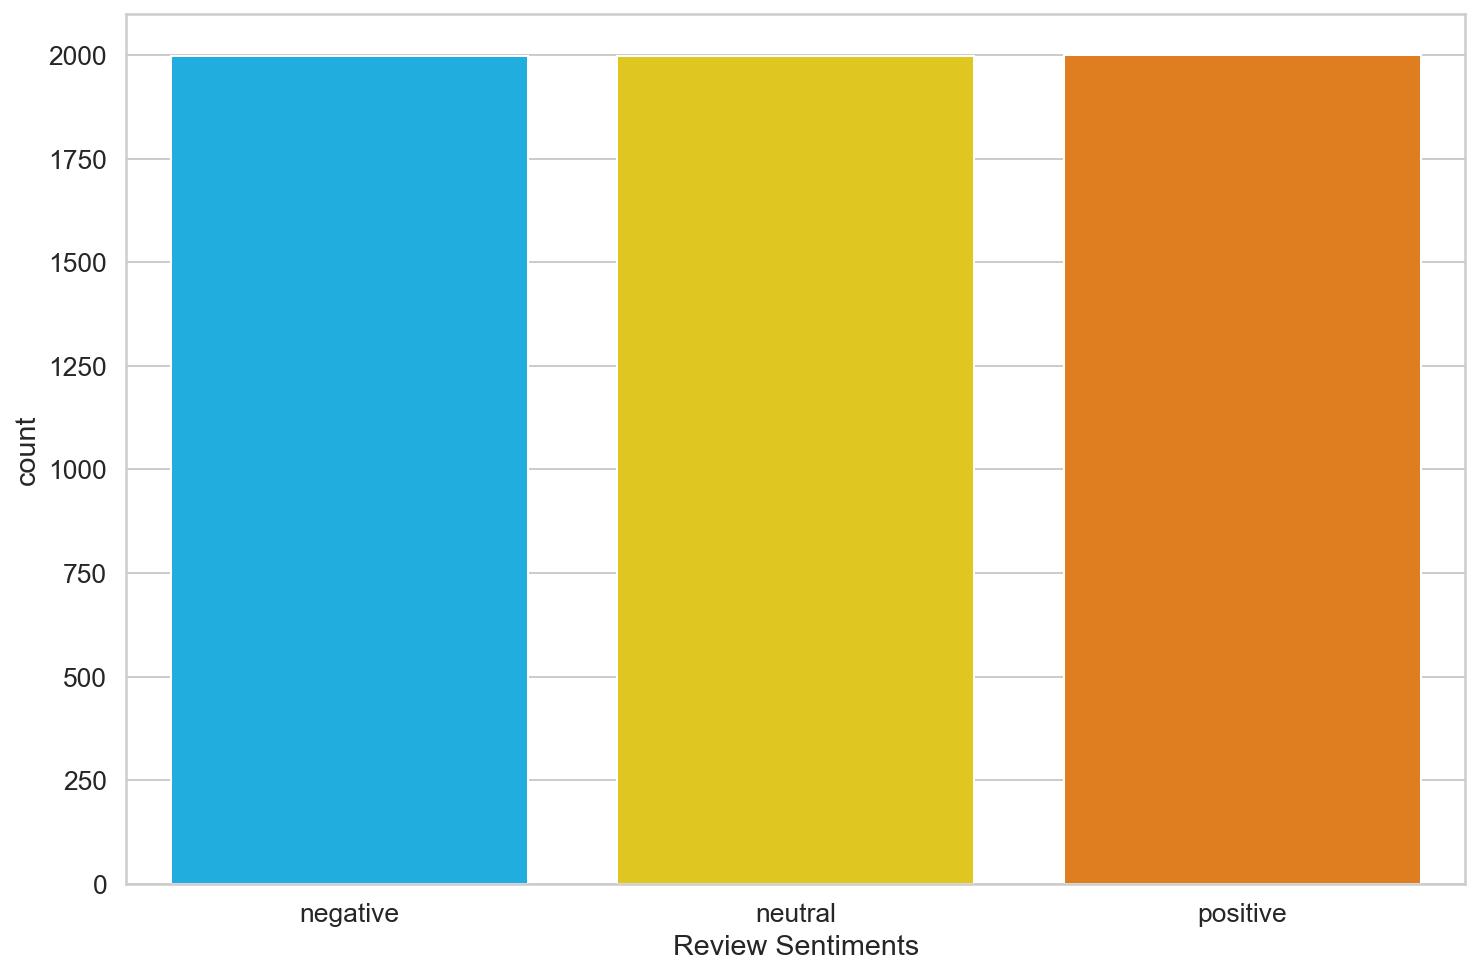

In [446]:
ax=sns.countplot(df_reduced['ratings'])
word_count=pd.value_counts(df_reduced['sentiment'].values, sort=True)
print(word_count)
plt.xlabel('Review Sentiments')
ax.set_xticklabels(class_names)
plt.savefig('class_balanced.png')

A function named 'Preprocessing' has been created for text cleaning and text pre-prcessing of the reviews before applying to machine learning algorithm 

In [293]:
# import the necessary libraries 
import nltk 
import string 
import re 


#Converting the sentence into lower case

def text_lowercase(text): 
	return text.lower()
  

# Remove numbers 
#def remove_numbers(text): 
#	result = re.sub(r'\d+', '', text) 
#	return result 

# import the inflect library 
import inflect 
p = inflect.engine() 

# convert number into words 
def convert_number(text): 
	# split string into list of words 
	temp_str = text.split() 
	# initialise empty list 
	new_string = [] 

	for word in temp_str: 
		# if word is a digit, convert the digit 
		# to numbers and append into the new_string list 
		if word.isdigit(): 
			temp = p.number_to_words(word) 
			new_string.append(temp) 

		# append the word as it is 
		else: 
			new_string.append(word) 

	# join the words of new_string to form a string 
	temp_str = ' '.join(new_string) 
	return temp_str 

# Expand the contraction terms
contractions_dict = {
        "ain't":"is not",
        "aint" : "is not",
        "amn't":"am not",
        "aren't":"are not",
        "arent":"are not,",
        "can't":"cannot",
        "cant":"cannot",
        "cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "dont":"do not",
        "didnt":"did not",
        "doesnt":"does not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "i'd":"i would",
        "I'll":"I will",
        "i'll":'i will',
        "I'm":"I am",
        "i'm":"i am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "isnt":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "itll":"it will",
        "it's":"it is",
        "i've":'i have',
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "lets":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "shant":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldnt":"should not",
        "shouldn't've":"should not have",
        "shouldntve":"should not have",
        "should've":"should have",
        "shouldve":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "wasnt":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wont":"will not",
        "wouldn't":"would not",
        "wouldnt":"would not",
        "would've":"would have",
        "wouldve":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "1st":"first",
        "2nd":"second",
        "cus":"because",
        "cuz":"because",
        "u":"you",
        "ff": "fast forward",
        "yrslf":"yourself",
        "hoped":"hope",
        "here's":"here is",
        "romcom":"romantic comedy",
        "rom-com":"romantic comedy"
        }
def contraction_expand(text):
    text=text.split()
    for i in range(0, len(text)):
        
        if text[i] in contractions_dict:
            text[i] = contractions_dict[text[i]]
    mess = ' '.join(text)
    return(mess) 

# remove punctuation 
def remove_punctuation(text): 
	translator = str.maketrans('', '', string.punctuation) 
	return text.translate(translator) 

# Remove Special Characters
def remove_special_characters(text):
    replaced = re.sub("[^a-z ]+", '', text)
    return(replaced)

# remove escape characters
def remove_escape_characters(text):
    replaced = re.sub("[\\n\\t]+", '', text)
    return(replaced)

# remove whitespace from text 
def remove_whitespace(text): 
	return " ".join(text.split()) 


from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# remove stopwords function 
def remove_stopwords(text):
    operators = set(('not','never', 'no','because','off','until','very'))
    stop = set(stopwords.words('english'))-operators
    nostopwords = [word for word in text.split() if word.lower() not in stop]
    nostopwords = ' '.join(nostopwords)
    return nostopwords


 
# Lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 
# lemmatize string 
def lemmatize_word(text): 
	word_tokens = word_tokenize(text) 
	# provide context i.e. part-of-speech 
	lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
	return lemmas 


def Preprocessing(input_str):
    input_str = text_lowercase(input_str)
    input_str = contraction_expand(input_str)
    input_str = convert_number(input_str)
    input_str = remove_numbers(input_str)
    input_str = remove_punctuation(input_str)
    input_str = remove_whitespace(input_str) 
    input_str = remove_escape_characters(input_str)
    input_str = remove_special_characters(input_str)
    input_str = remove_stopwords(input_str)
    input_str = lemmatize_word(input_str)
    return input_str
 



Checking the pre-processed text data on a sample review.

In [231]:
print(df_reduced['text'][11])

Picture was awful Story was awful
Worst movie I've seen in a long time
Very disappointed
Picture very fuzzy


In [232]:
print(Preprocessing(df_reduced['text'][11]))

['picture', 'awful', 'story', 'awful', 'worst', 'movie', 'see', 'long', 'time', 'very', 'disappoint', 'picture', 'very', 'fuzzy']


Dividing the dataset into training (80%) and test dataset (20%)

In [88]:
from sklearn.model_selection import train_test_split
X = df_reduced['text']
y = df_reduced['ratings']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [294]:
df_reduced['text_prep'] = df_reduced['text'].apply(lambda x:Preprocessing(x))
df_reduced.head()

,text,reviewerName,overallscore,sentiment,Length,score,ratings,text_prep
0,If you are wondering why I am reccomending Sou...,Stephen Verhaeren,1.0,Negative,288,1,0,"[wonder, reccomending, sout, park, bigger, lon..."
1,dont waste your money on this horrible excuse...,Gregor Slaughter,1.0,Negative,138,1,0,"[not, waste, money, horrible, excuse, star, wa..."
2,"Gee, where does one begin with this cartoonish...","Robert A., Shoaf",1.0,Negative,185,1,0,"[gee, one, begin, cartoonish, excuse, real, mo..."
3,"Another typical piece of Troma Trash, I am unf...",Roule Duke,1.0,Negative,23,1,0,"[another, typical, piece, troma, trash, unfort..."
4,This was absolutely awful. We should have tur...,Charles R. Maner,1.0,Negative,21,1,0,"[absolutely, awful, turn, off, first, two, min..."


Creation of Word Cloud

In [316]:
words = list(map(' '.join, df_reduced['text_prep']))
words = str(words)
split_word = " ".join([word for word in words.split()])

In [334]:
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(split_word)

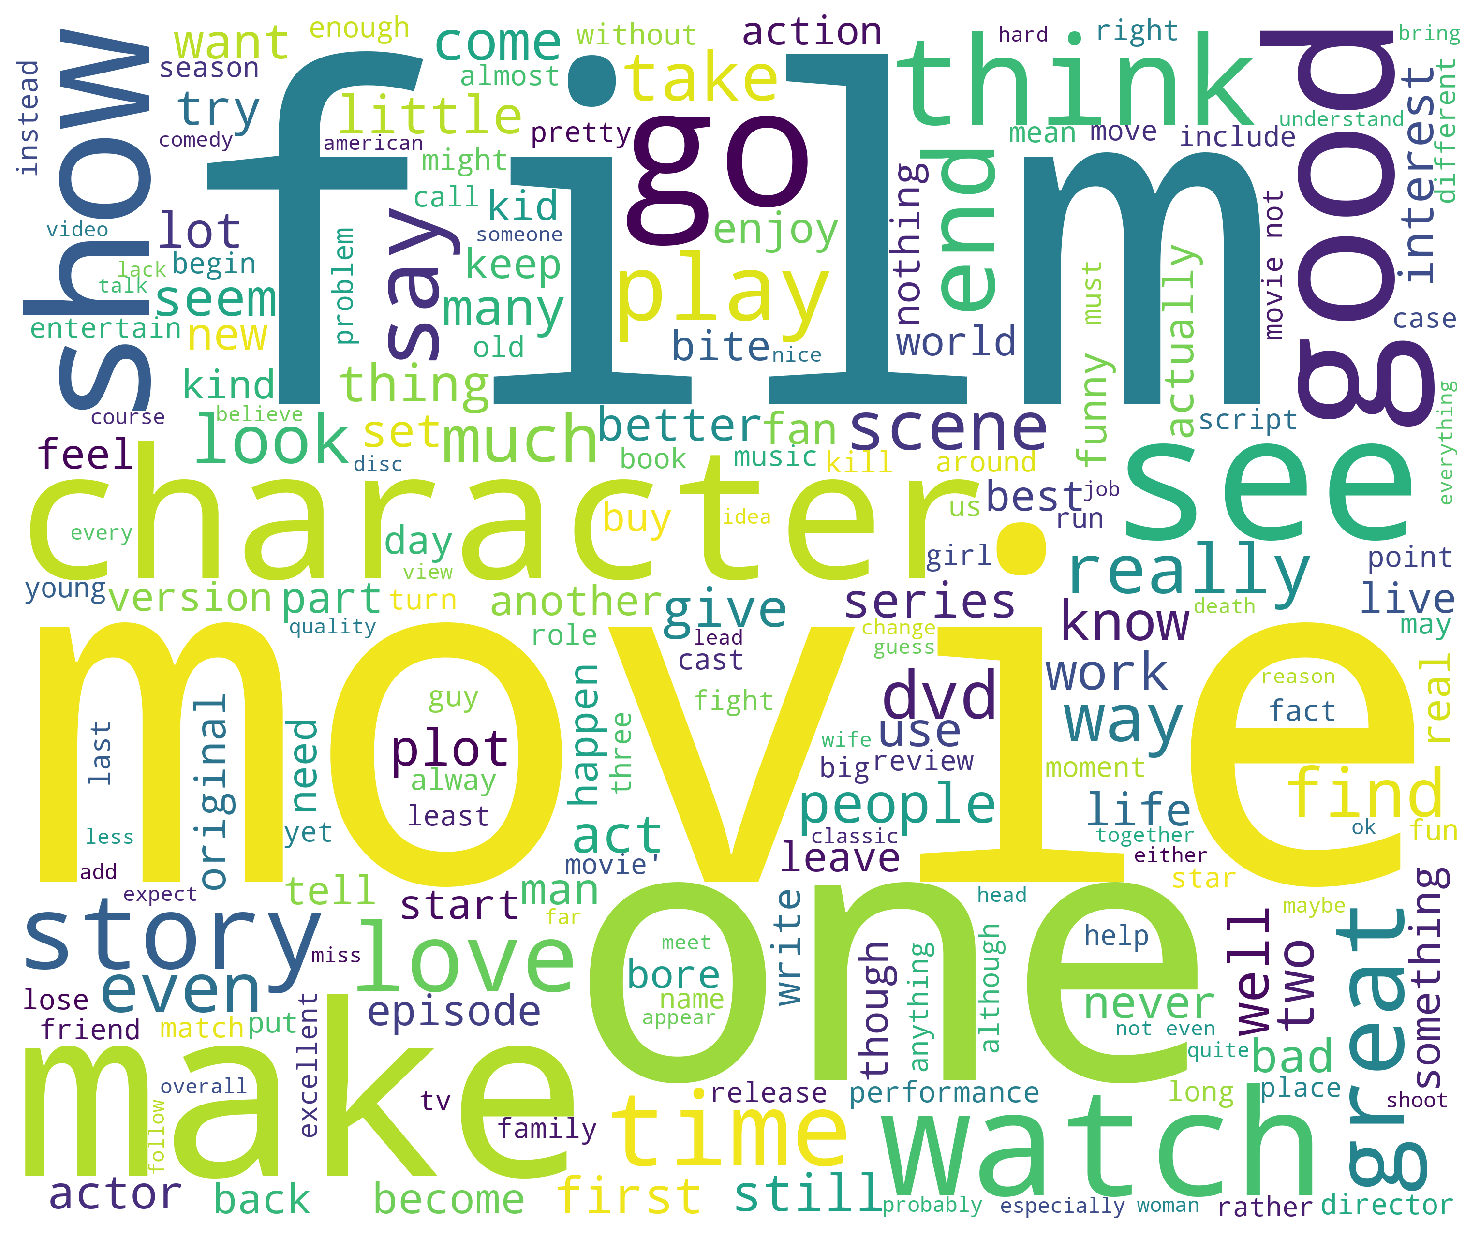

In [380]:
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud.to_file('wordcloud1.png')

In [443]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5997 entries, 0 to 5996
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          5997 non-null   object 
 1   reviewerName  5997 non-null   object 
 2   overallscore  5997 non-null   float64
 3   sentiment     5997 non-null   object 
 4   Length        5997 non-null   int64  
 5   score         5997 non-null   int32  
 6   ratings       5997 non-null   int64  
 7   text_prep     5997 non-null   object 
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 351.5+ KB


## Applying Machine Learning Algorithms

1. Naive Bayes Algorithm 

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [390]:
pipeNB = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [391]:
pipeNB.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function Preprocessing at 0x000002390DBA5708>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [392]:
pred = pipeNB.predict(x_test)

Classification Report of Naive Bayes Algorithm

In [393]:

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       433
           1       0.48      0.61      0.54       392
           2       0.68      0.50      0.57       375

    accuracy                           0.59      1200
   macro avg       0.60      0.59      0.59      1200
weighted avg       0.61      0.59      0.59      1200



Confusion Matrix of Naive Bayes Algorithm

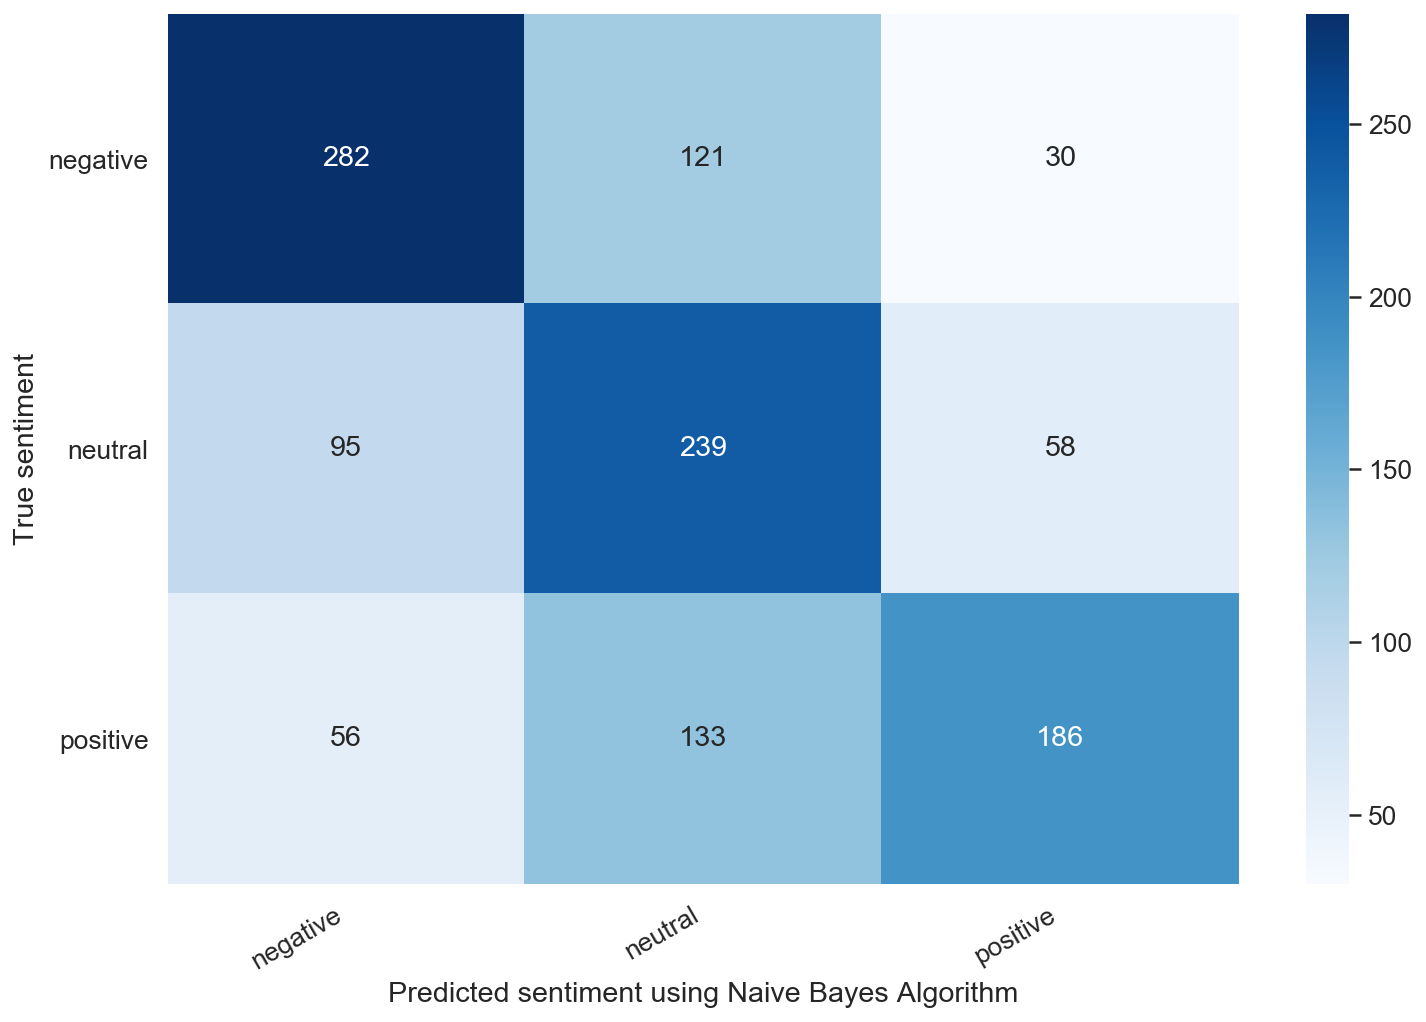

In [394]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment using Naive Bayes Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
# plt.savefig("confusion_matrix_Naive_Bayes.png")

2. Random Forest Algorithm


Classification Report of Random Forest

In [395]:
from sklearn.ensemble import RandomForestClassifier
pipeRFC = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

pipeRFC.fit(x_train,y_train)
pred = pipeRFC.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67       433
           1       0.52      0.52      0.52       392
           2       0.64      0.61      0.62       375

    accuracy                           0.61      1200
   macro avg       0.61      0.60      0.60      1200
weighted avg       0.61      0.61      0.61      1200



Confusion Matrix of Random Forest

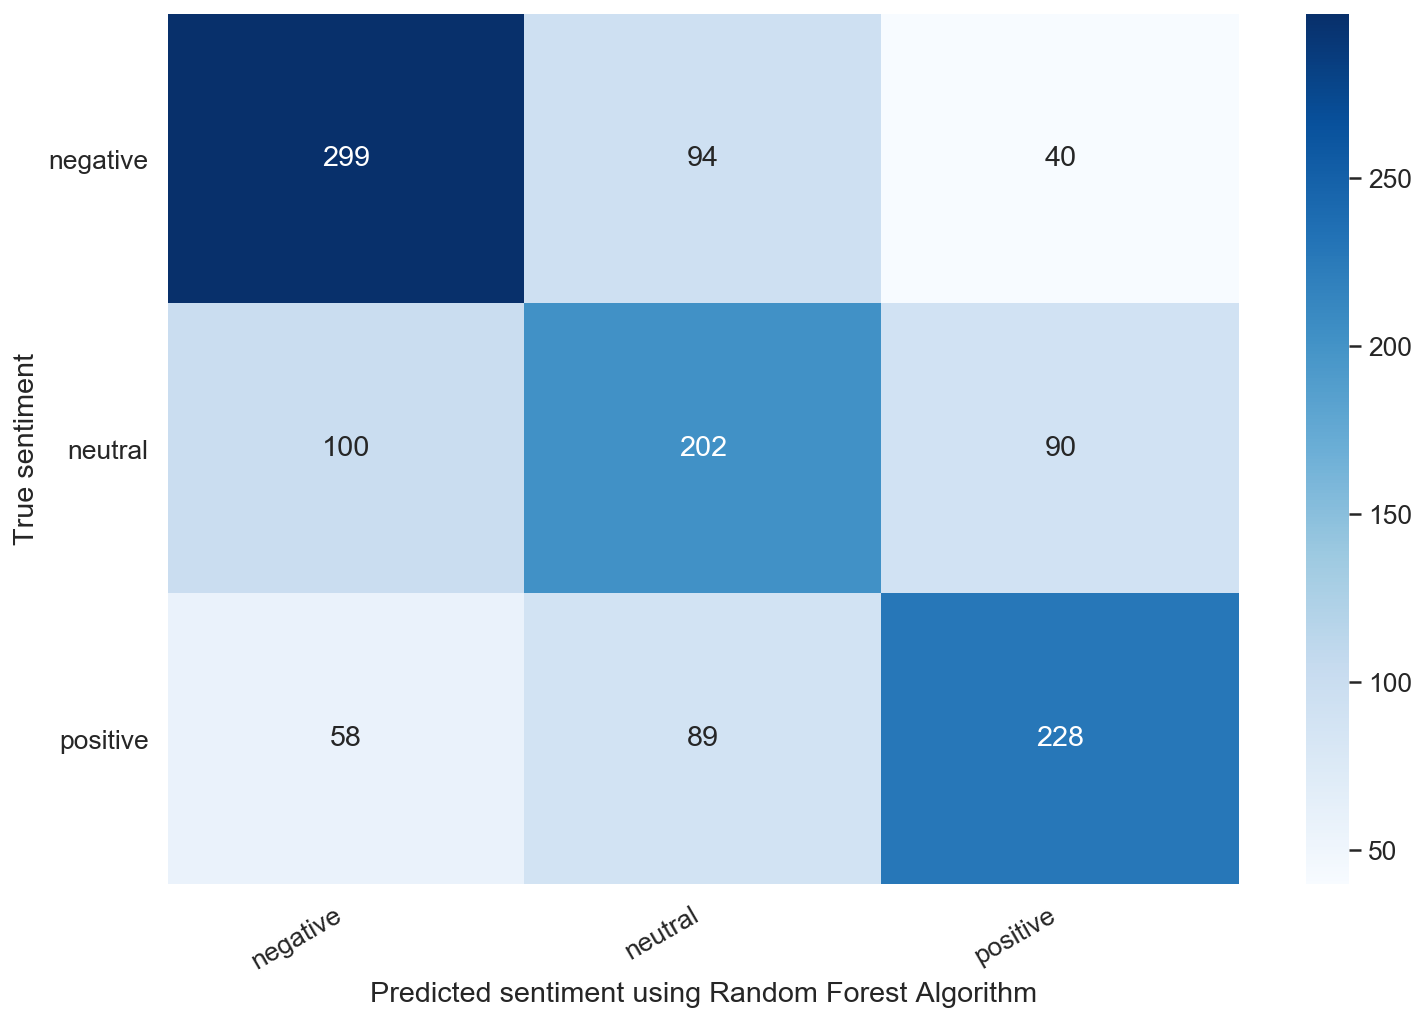

In [396]:
# def show_confusion_matrix(confusion_matrix):
#   hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#   hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#   hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#   plt.ylabel('True sentiment')
#   plt.xlabel('Predicted sentiment using Random Forest Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
# plt.savefig("confusion_matrix_RF.png")

3. Support Vector Machine

Classification Report of Support Vector Machine Algorithm

In [397]:
from sklearn.svm import SVC
pipeSVM = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC(kernel='linear'))
])

pipeSVM.fit(x_train,y_train)
pred = pipeSVM.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       433
           1       0.50      0.50      0.50       392
           2       0.63      0.65      0.64       375

    accuracy                           0.60      1200
   macro avg       0.60      0.60      0.60      1200
weighted avg       0.60      0.60      0.60      1200



Confusion Matrix of Support Vector Machine Algorithm

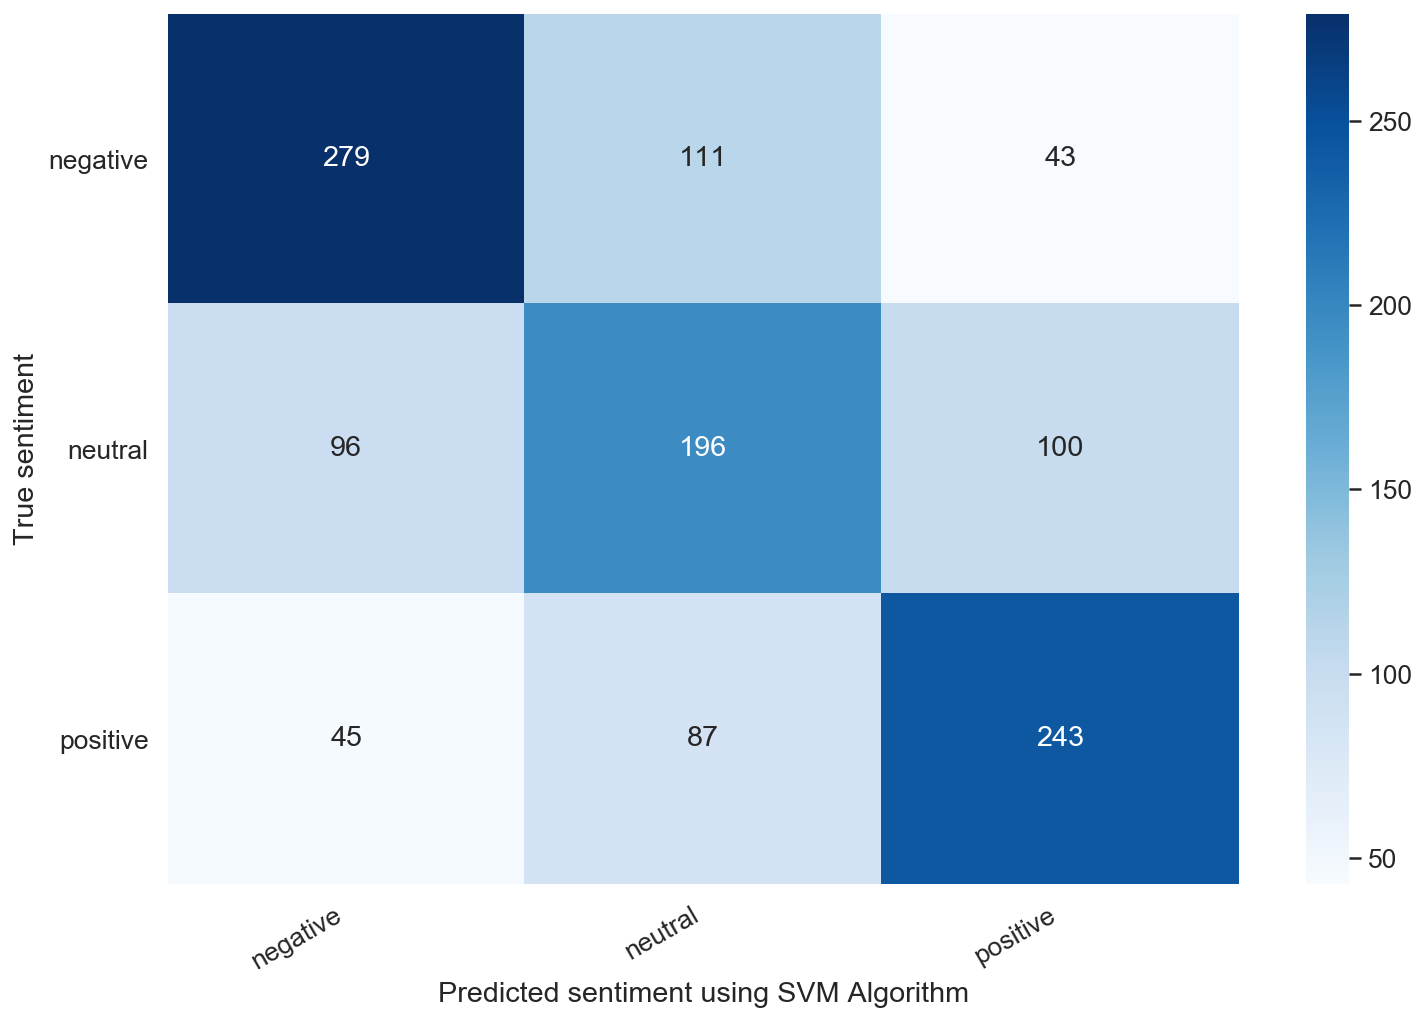

In [398]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment using SVM Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
# plt.savefig("confusion_matrix_SVM.png")

4. KNN Classifier


Classification Report of KNN Algorithm

In [401]:
from sklearn.neighbors import KNeighborsClassifier
pipeKNN = Pipeline([
    ('bow',CountVectorizer(analyzer=Preprocessing)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=3))
])
pipeKNN.fit(x_train,y_train)
pred = pipeKNN.predict(x_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.70      0.14      0.23       433
           1       0.34      0.89      0.50       392
           2       0.63      0.16      0.25       375

    accuracy                           0.39      1200
   macro avg       0.56      0.40      0.33      1200
weighted avg       0.56      0.39      0.32      1200



Confusion Matrix of KNN Algorithm

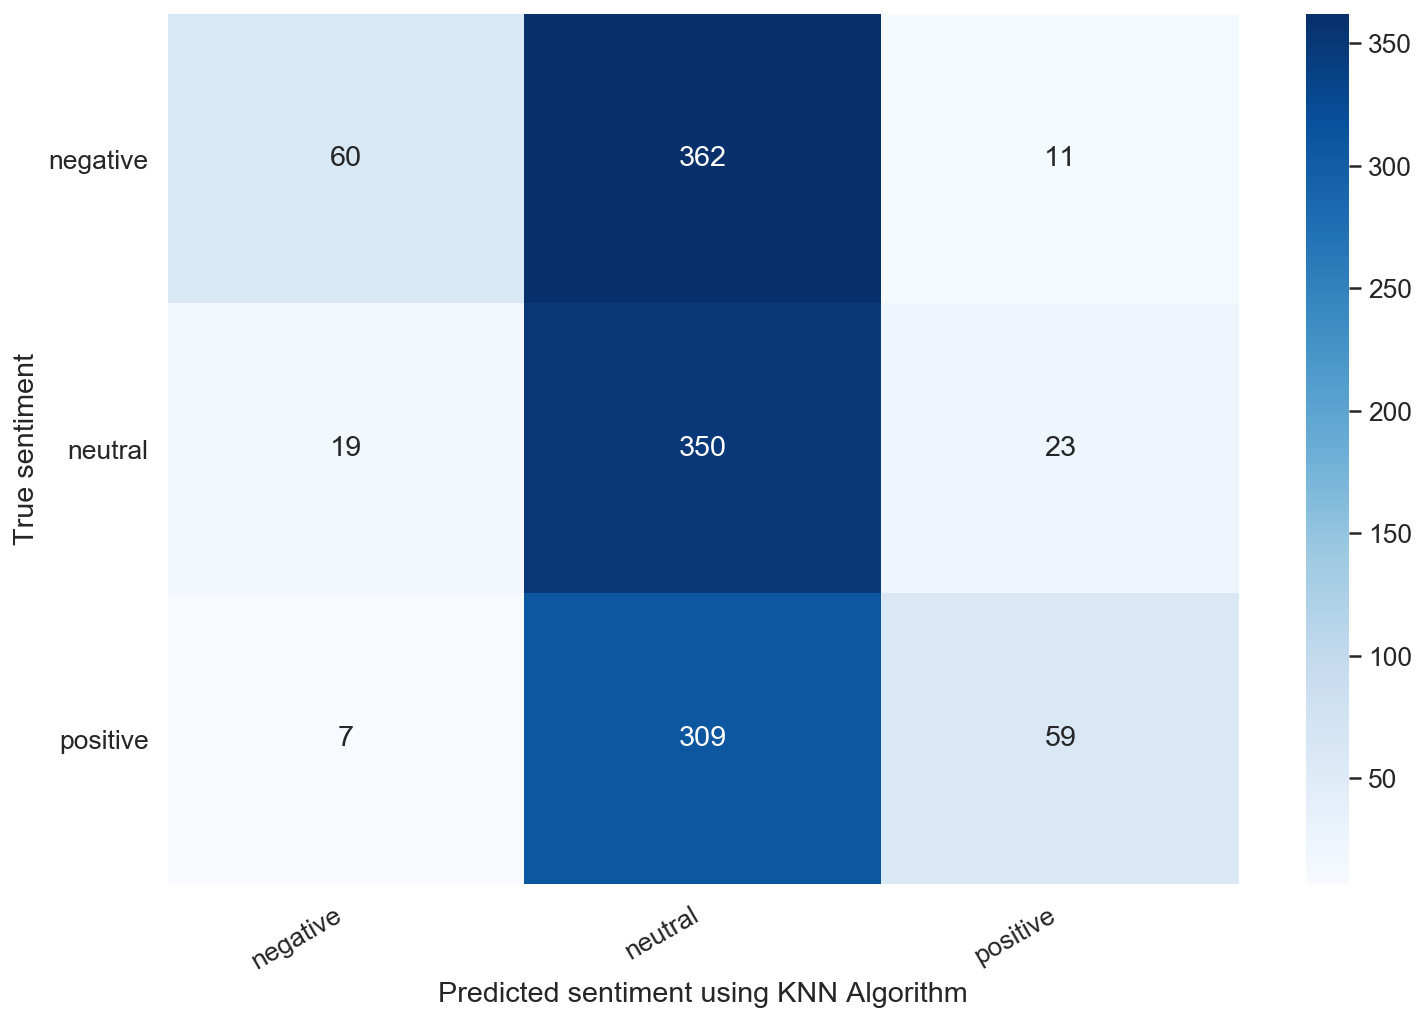

In [402]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment using KNN Algorithm');
cm = confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
# plt.savefig("confusion_matrix_KNN.png")

## BERT Algorithm

Pre-processing of the data for BERT algorithm

In [ ]:
# pip install transformers

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [281]:
sample_txt = 'When was I last outside? I am stuck at home for 3 months due to the current situation.'

In [282]:
tokens = tokenizer.tokenize(sample_txt)

In [283]:
print(len(tokens))
print(tokens)

20
['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '3', 'months', 'due', 'to', 'the', 'current', 'situation', '.']


In [287]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f' Sentence: {tokens}')
print(f' Sentence: {token_ids}')
print(encoding['attention_mask'])

 Sentence: When was I last outside? I am stuck at home for 3 months due to the current situation.
 Sentence: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '3', 'months', 'due', 'to', 'the', 'current', 'situation', '.']
 Sentence: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 124, 1808, 1496, 1106, 1103, 1954, 2820, 119]
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [29]:
tokenizer.sep_token, tokenizer.sep_token_id




('[SEP]', 102)

In [30]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [31]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [32]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [285]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt',
    truncation=True
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [286]:
encoding['input_ids']
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
token_lens = []
ln = max(df_reduced['Length'])
for txt in df_reduced.text:
  tokens = tokenizer.encode(txt, max_length=ln)
  token_lens.append(len(tokens))

In [438]:
print(token_lens)

[418, 157, 272, 34, 24, 27, 44, 215, 54, 16, 923, 23, 8, 360, 512, 9, 24, 15, 4, 468, 66, 108, 82, 31, 96, 24, 204, 105, 208, 163, 82, 11, 153, 83, 15, 206, 8, 68, 84, 257, 20, 161, 51, 25, 117, 112, 18, 29, 4, 77, 153, 154, 10, 127, 9, 132, 3, 76, 176, 70, 12, 851, 44, 856, 11, 45, 15, 5, 35, 13, 10, 41, 29, 20, 91, 130, 89, 367, 58, 133, 129, 461, 63, 138, 19, 99, 26, 3, 1165, 9, 46, 409, 29, 53, 22, 4, 9, 34, 45, 67, 39, 137, 1559, 87, 452, 33, 5, 11, 151, 174, 40, 42, 53, 8, 20, 159, 53, 45, 102, 9, 17, 31, 354, 6, 18, 294, 90, 236, 6, 3, 82, 3, 153, 95, 55, 49, 38, 701, 497, 1769, 622, 15, 72, 58, 205, 142, 520, 86, 76, 24, 202, 195, 420, 42, 355, 86, 26, 18, 388, 58, 50, 58, 348, 9, 34, 22, 182, 70, 27, 254, 189, 21, 5, 1181, 111, 130, 33, 7, 15, 158, 4, 178, 5, 32, 661, 6, 543, 8, 46, 16, 590, 22, 44, 25, 34, 8, 132, 150, 8, 158, 17, 119, 236, 5, 129, 203, 182, 56, 44, 244, 36, 58, 31, 176, 39, 43, 119, 537, 369, 12, 10, 71, 179, 182, 15, 7, 25, 129, 24, 105, 32, 126, 55, 126, 3

Plotting a graph to show the length of reviews 

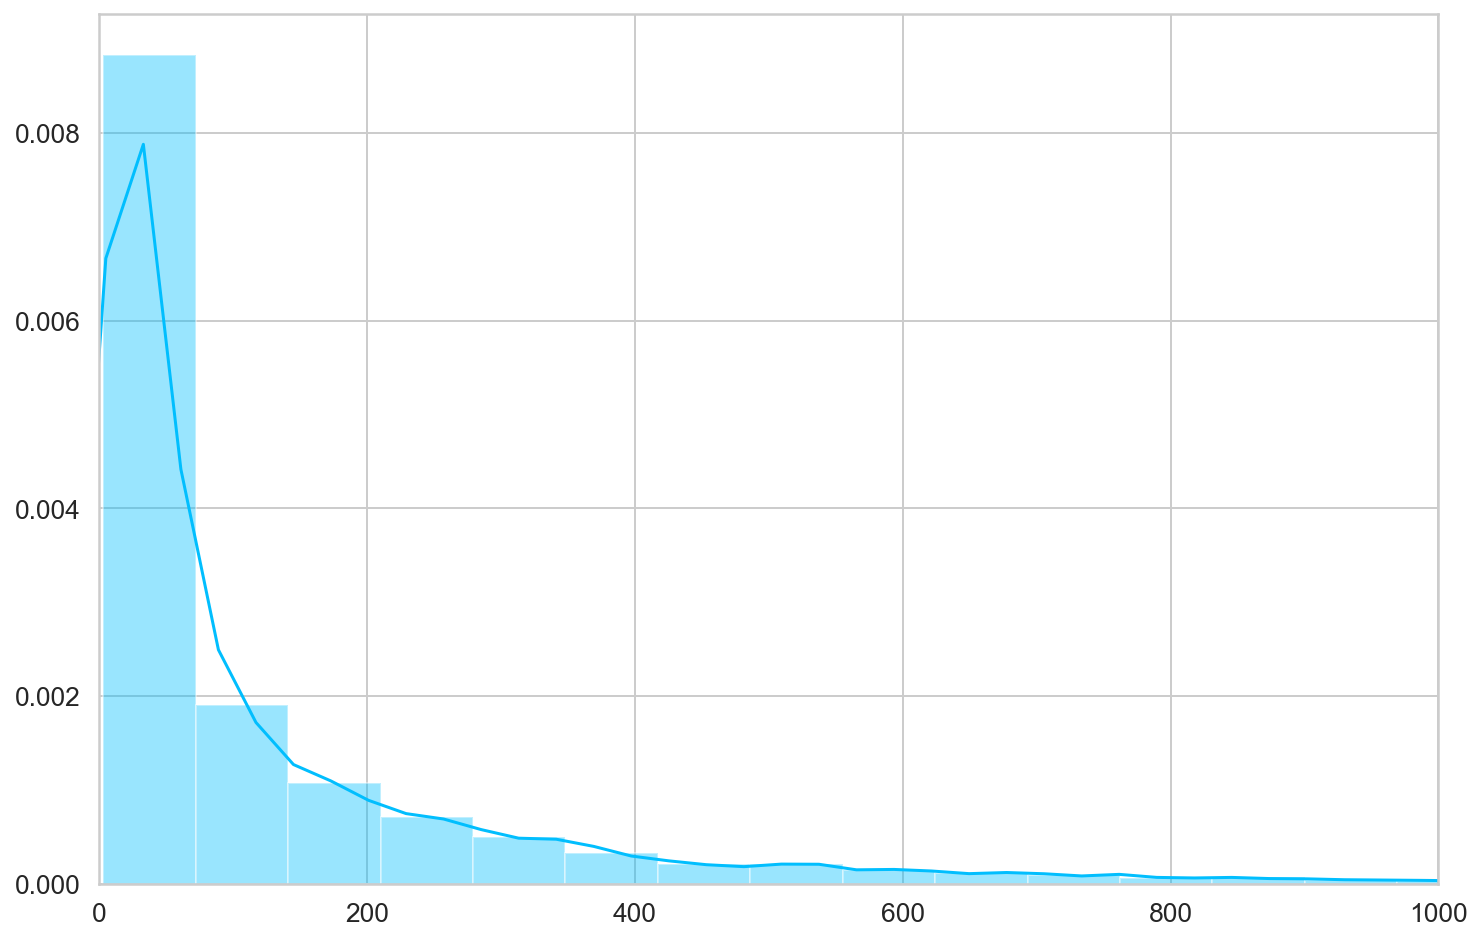

In [442]:
sns.distplot(token_lens)
plt.xlim(0, 1000)

plt.savefig("len.png")

Creating a class to read the Dataset

In [41]:
class ReviewDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.review)
    def __getitem__(self, item):
        review = str(self.review[item])
        target=self.target[item]
    
    encoding = tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      truncation=True,
      return_tensors='pt'
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(self.target[item], dtype=torch.long)
    }




Setting certain parameters for the BERT Algorithm

In [42]:
MAX_LEN = 200
BATCH_SIZE = 16
EPOCHS = 20

Dividing the data into training , validation and test datasets

In [43]:
df_train, df_test = train_test_split(df_reduced, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_reduced, test_size=0.5, random_state=42)

In [44]:
df_train.shape, df_val.shape, df_test.shape

((4797, 7), (2998, 7), (2999, 7))

Creating dataloaders for train, test and validation datasets

In [45]:
def createDataLoader(df_reduced, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
    review = df_reduced.text.to_numpy(),
    target = df_reduced.ratings.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len
  )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
    )  

In [46]:
train_data_loader = createDataLoader(df_train,tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = createDataLoader(df_val,tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = createDataLoader(df_test,tokenizer, MAX_LEN, BATCH_SIZE)

In [48]:
data = next(iter(train_data_loader))


Using Cased BERT pre-trained model

In [49]:
PRE_TRAINED_MODEL_NAME='bert-base-cased'

In [50]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [51]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [52]:
last_hidden_state.shape
pooled_output.shape

torch.Size([1, 768])

In [53]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [54]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [55]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 200])
torch.Size([16, 200])


In [56]:
model(input_ids, attention_mask)

tensor([[0.4925, 0.1974, 0.3101],
        [0.4112, 0.1278, 0.4610],
        [0.4755, 0.1285, 0.3961],
        [0.4895, 0.1025, 0.4080],
        [0.4199, 0.1518, 0.4283],
        [0.3354, 0.1622, 0.5024],
        [0.4456, 0.1616, 0.3928],
        [0.3892, 0.1892, 0.4216],
        [0.4247, 0.1069, 0.4684],
        [0.5079, 0.1394, 0.3527],
        [0.4357, 0.1827, 0.3817],
        [0.3665, 0.1209, 0.5126],
        [0.5247, 0.1094, 0.3660],
        [0.3034, 0.2561, 0.4405],
        [0.3121, 0.1116, 0.5763],
        [0.6027, 0.1120, 0.2853]], grad_fn=<SoftmaxBackward>)

Creating an optimizer with Adamw of 2e^(-5)

In [57]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Determining a function to train the data on the machine

In [58]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):

    model = model.train()

  losses = []
  correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [59]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

Checking the training and validation accuarcies of the respective dataset for 20 epochs

In [60]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler, 
        len(df_train)
        )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.9581249229113261 accuracy 0.5628517823639775
Val   loss 0.8511394715689599 accuracy 0.6957971981320881

Epoch 2/20
----------
Train loss 0.842041588028272 accuracy 0.7000208463623098
Val   loss 0.7845565873257657 accuracy 0.7598398932621748

Epoch 3/20
----------
Train loss 0.7838549129168193 accuracy 0.7629768605378362
Val   loss 0.765374501968952 accuracy 0.7841894596397598

Epoch 4/20
----------
Train loss 0.7556259999672572 accuracy 0.7915363769022306
Val   loss 0.7191922797801646 accuracy 0.8318879252835224

Epoch 5/20
----------
Train loss 0.7225580366452535 accuracy 0.8271836564519491
Val   loss 0.7203578492428394 accuracy 0.8302201467645097

Epoch 6/20
----------
Train loss 0.7075480651855469 accuracy 0.8426099645611841
Val   loss 0.6774912584335246 accuracy 0.872248165443629

Epoch 7/20
----------
Train loss 0.6854589990774791 accuracy 0.8653324994788409
Val   loss 0.6704709989593384 accuracy 0.8812541694462975

Epoch 8/20
----------
Train lo

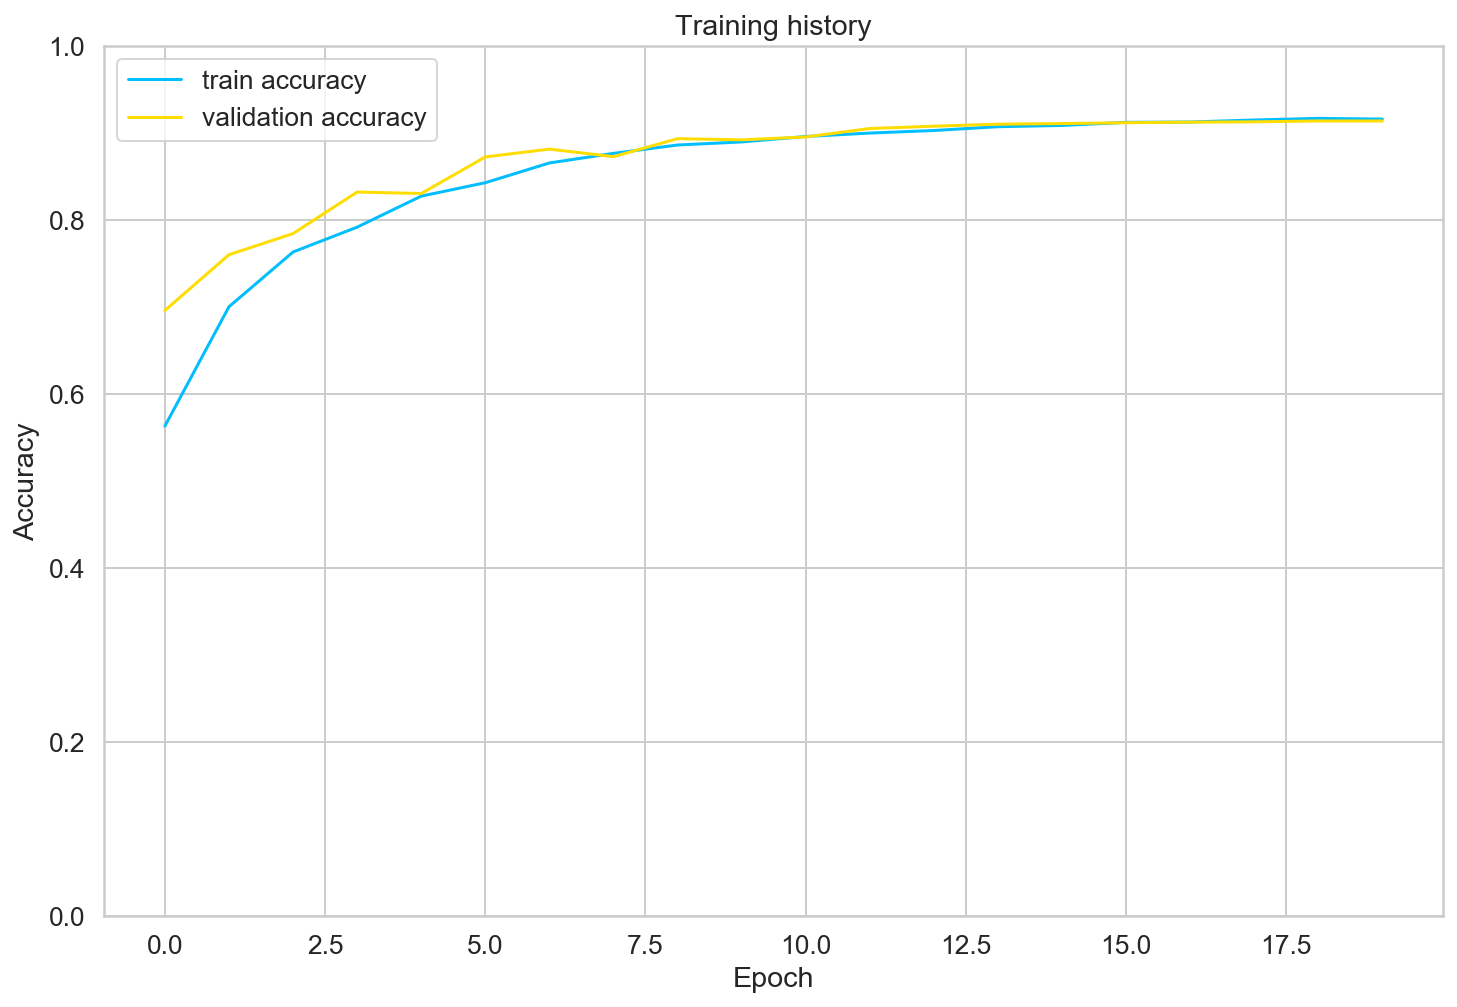

In [61]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.savefig("training_history.png")

Finding the test data's accuracy

In [62]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.8222740913637879

In [63]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                  )
        _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            predictions = torch.stack(predictions).cpu()
            prediction_probs = torch.stack(prediction_probs).cpu()
            real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [3]:
# import pickle

In [71]:
# filename = 'model_bert1.sav'
# pickle.dump(model, open(filename, 'wb'))

In [69]:
# loaded_model = pickle.load(open(filename, 'rb'))

In [64]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Confusion Matrix of the BERT Algorithm

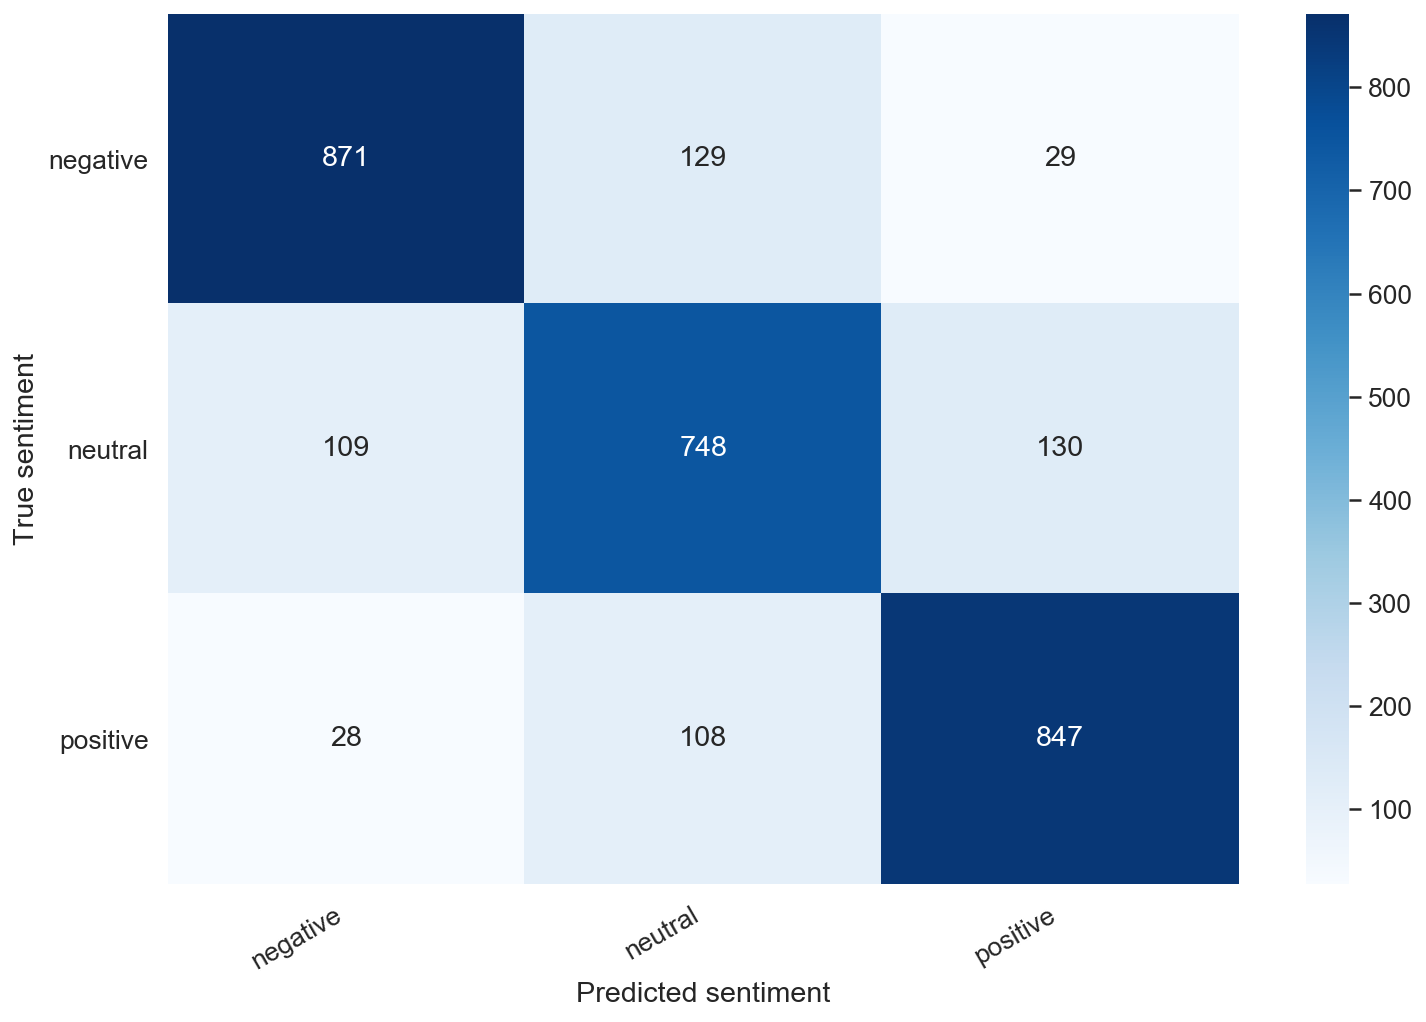

In [70]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
plt.savefig("confusion_matrix_bert.png")

Checking the working of BERT model on sample text

In [430]:
# An example to review the working of model
review_text = "I received this DVD with a huge hole in it."

In [431]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [432]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I received this DVD with a huge hole in it.
Sentiment  : negative
